### Helper for loading the datasets

In [94]:
import pandas as pd
from usp_stream_datasets import *

pd.set_option('mode.use_inf_as_na', True)

dataset = "Incremental-gradual (imbal.)"
df_data = load_insect_dataset(insects_datasets[dataset]["filename"])

### Load a specific Dataset

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


species = b"ae-aegypti-female"
att = "Att2"

df_aedes = df_data[df_data["class"] == species]
df = df_aedes
num_chunks = 8

# Calculate the chunk size based on the number of chunks
chunk_size = len(df) // num_chunks + 1

# Generate chunk IDs
chunk_ids = np.repeat(range(num_chunks), chunk_size)[:len(df)]

# Add chunk IDs to DataFrame
df['chunk_id'] = chunk_ids

# Split the DataFrame into chunks based on chunk IDs
chunks = [group for _, group in df.groupby('chunk_id')]

# Concatenate chunks back together if needed
concatenated_df = pd.concat(chunks, ignore_index=True)

# # Plot 
# plt.figure(figsize=(10,20))
# sns.displot(concatenated_df, x=att, hue="chunk_id", kind="kde").set(title=f'Plot for {att} of species {species}')
# plt.show()

/tmp/ipykernel_40/3108970697.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chunk_id'] = chunk_ids


In [96]:
# df.columns

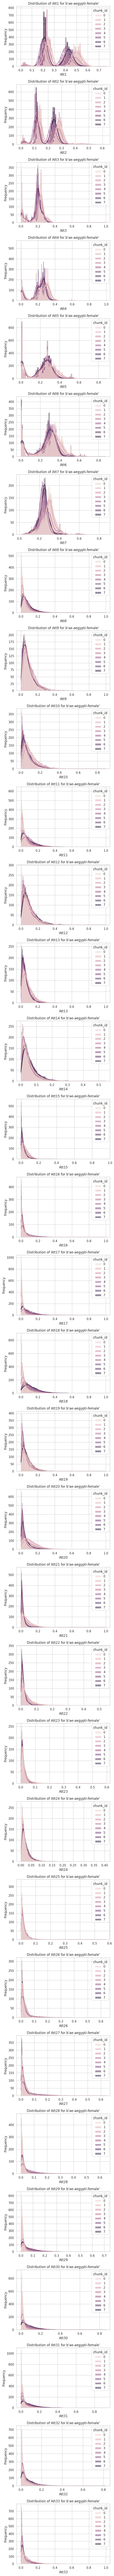

In [97]:
df = concatenated_df

# Set the style of the plots
sns.set(style="whitegrid")

# Get the list of column names
columns = ['Att1', 'Att2', 'Att3', 'Att4', 'Att5', 'Att6', 'Att7', 'Att8', 'Att9',
       'Att10', 'Att11', 'Att12', 'Att13', 'Att14', 'Att15', 'Att16', 'Att17',
       'Att18', 'Att19', 'Att20', 'Att21', 'Att22', 'Att23', 'Att24', 'Att25',
       'Att26', 'Att27', 'Att28', 'Att29', 'Att30', 'Att31', 'Att32', 'Att33']

# Calculate the number of rows and columns for subplots
n_rows = len(columns)
n_cols = 1

# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 4 * n_rows))

# Loop through each column and create a distribution plot
for i, column in enumerate(columns):
    ax = axes[i] if n_rows > 1 else axes  # Handle single-row case
    sns.histplot(data=df, x=column, ax=ax, kde=True, hue="chunk_id")  # You can use other Seaborn functions like sns.distplot if needed
    ax.set_title(f'Distribution of {column} for {species}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Kolmogorov Smirnov Test

Suppose we wish to test the null hypothesis that both samples have the same distribution. We choose a confidence level of 95%; that is, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05.


In [98]:
from scipy import stats

In [99]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def ks_test_att(df, atr_col):
    a = [item for item in range(num_chunks)]
    answer = []
    for v, w in pairwise(a):
        sample_a = df[(df['chunk_id'] == v)][atr_col]
        sample_b = df[(df['chunk_id'] == w)][atr_col]
        print("Sizes: ", sample_a.size, sample_b.size)
        ks = stats.kstest(sample_a, sample_b)
        print(f"The ks test for sample {v},{w} is:", ks)
        if ks.pvalue < 0.05:
            action = "reject"
        else:
            action = "accept"
        answer.append({"attr": atr_col, "range": (v,w), "action": action, "p-value": ks.pvalue, "statistic": ks.statistic})
    return answer

test_lists = [ks_test_att(df, atr) for atr in columns]
tests = [item for test_list in test_lists for item in test_list]

Sizes:  3779 3779
The ks test for sample 0,1 is: KstestResult(statistic=0.04974861074358296, pvalue=0.0001730007784685787)
Sizes:  3779 3779
The ks test for sample 1,2 is: KstestResult(statistic=0.10902355120402223, pvalue=5.718550280753871e-20)
Sizes:  3779 3779
The ks test for sample 2,3 is: KstestResult(statistic=0.17941254300079387, pvalue=1.55842510284165e-53)
Sizes:  3779 3779
The ks test for sample 3,4 is: KstestResult(statistic=0.17835406192114317, pvalue=6.620103606022493e-53)
Sizes:  3779 3779
The ks test for sample 4,5 is: KstestResult(statistic=0.12622386874834612, pvalue=1.2198124467646211e-26)
Sizes:  3779 3779
The ks test for sample 5,6 is: KstestResult(statistic=0.034136014818735114, pvalue=0.024461049646425308)
Sizes:  3779 3778
The ks test for sample 6,7 is: KstestResult(statistic=0.022878866814474853, pvalue=0.2702788757994016)
Sizes:  3779 3779
The ks test for sample 0,1 is: KstestResult(statistic=0.03889917967716327, pvalue=0.006566868905236676)
Sizes:  3779 3779
T

In [100]:
x = pd.DataFrame(tests)

In [101]:
x.action.value_counts()

reject    183
accept     48
Name: action, dtype: int64

In [102]:
x[(x.action == "accept")]

,attr,range,action,p-value,statistic
6,Att1,"(6, 7)",accept,0.270279,0.022879
12,Att2,"(5, 6)",accept,0.091310,0.028579
13,Att2,"(6, 7)",accept,0.536052,0.018391
20,Att3,"(6, 7)",accept,0.266149,0.022935
27,Att4,"(6, 7)",accept,0.466836,0.019417
34,Att5,"(6, 7)",accept,0.063611,0.030057
48,Att7,"(6, 7)",accept,0.373064,0.020893
49,Att8,"(0, 1)",accept,0.068161,0.029902
55,Att8,"(6, 7)",accept,0.219078,0.024018
62,Att9,"(6, 7)",accept,0.207802,0.024307
